In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import astropy.constants as cte
import astropy.units as un
import astropy.cosmology
from astropy.cosmology import Planck15 as cosmo
import emcee
import scipy.optimize as op

In [2]:
import dust_emissivity

In [3]:
Msun=cte.M_sun
c=cte.c

In [4]:
file = open("/Users/mariajesusfloresmoraga/Desktop/DSFG/T1 f2.csv")
csvreader = csv.reader(file)
header = []
header = next(csvreader)

rows = []
for row in csvreader:
        rows.append(row)

ID= []

v1=[]
ev1=[]

v2=[]
ev2=[]

v3=[]
ev3=[]

l1=[]
el1=[]

l2=[]
el2=[]

l3=[]
el3=[]


for j in rows:   
    
    ID.append(j[0])
    
    v1.append(float(j[3]))
    ev1.append(float(j[4]))
    v2.append(float(j[5]))
    ev2.append(float(j[6]))
    v3.append(float(j[7]))
    ev3.append(float(j[8]))
    l1.append(float(j[9]))
    el1.append(float(j[10]))
    l2.append(float(j[11]))
    el2.append(float(j[12]))
    l3.append(float(j[13]))
    el3.append(float(j[14]))


In [5]:
v_=[148,218,278]*un.GHz
l__=[500,350,250]*un.um
v=v_.to("Hz").value
l_=c/(np.array([500,350,250])*un.um)
l=l_.to("Hz").value
vf=np.concatenate((v, l))

In [6]:
frecs0T=np.array([v1[0],v2[0],v3[0],l1[0],l2[0],l3[0]])
errf0T=np.array([ev1[0],ev2[0],ev3[0],el1[0],el2[0],el3[0]])

In [7]:
frecs0=np.array([[v1[0],v2[0],v3[0]],[l1[0],l2[0],l3[0]]])
errf0=np.array([[ev1[0],ev2[0],ev3[0]],[el1[0],el2[0],el3[0]]])

In [8]:
def tau(z,M_,d_,vf): 
    v0=355*un.GHz
    b=2
    M=Msun * 10** M_
    k0=0.15*(un.m**2/un.kg) 
    tau=k0*(vf/v0)**b *(z+1)**b * M/(np.pi*(d_/2)**2)
    return tau.to("")

In [9]:
def P(vf,T,z):
    h=cte.h
    K=cte.k_B
    A=2*h/(c**2)
    a=(h*vf*(1+z)/(K*T))
    B=vf**3/(np.e**(a.value) -1)
    P=(A*B).to("mJy")
    return P

In [10]:
def modelSv(z,T,M_,d_,vf):
    b=2
    v0=350*un.GHz
    D=cosmo.angular_diameter_distance(z)
    #print("Angular diameter distance:{}".format(D.to("Mpc")))
    M=Msun*(10**M_)
    d=d_
    O=np.pi*(d/2)**2 * (D**-2)
    #print(tau(z,b,M_,d_,vf,v0))
    S_=O*(1-np.e**-tau(z,M_,d_,vf))*P(vf,T,z)
    S=S_.to("mJy")
    return S

In [11]:
#wrapper del modelo

def fit_bb(x, *p):
    #dejar una descripcion de los parametros que entran en la funcion entre comillas al comienzo
    """
    x : frecuencia *un.Hz ------> por alguna razon esto esta en Hz pero el v0 por ejemplo en GHz
    p = z T M d  ---------------> parametros a fitear   
    z : redshift (adimensional)
    T : temperatura en Kelvin pero sin usar unidades
    M : log(mu M/M_sun) (adimensional)
    d : distance *en kpc pero sin usar unidades
    
    return: modelo en mJy pero sin unidades
    """
    #queda definido dentro el valor de b y v0 que no se cambian nunca
    b = 2.0
    v0 = 353*un.GHz
    
    return modelSv(p[0],p[1]*un.K,p[2],p[3]*un.kpc,x)

In [12]:
def lnlike(theta,x,y,yerr):
    lnf,z,T,M,d = theta
    x = x*un.Hz
    modelSv = fit_bb(x,z,T,M,d).value
    inv_sigma2 = 1.0 / (yerr**2 + (modelSv)**2 * np.exp(2*lnf))
    return -0.5 * np.sum((y-(modelSv))**2*inv_sigma2 - np.log(inv_sigma2))

ACT-S J0011-0018

In [13]:
z0=3.3
T0=45.9*un.K
M0_=9.45
d0_=2.9*un.kpc

model0=modelSv(z0,T0,M0_,d0_,vf*un.Hz).to("mJy")

In [14]:
x0 = np.linspace(100,2000,100)*un.GHz
x0 = x0.to("Hz")

p = [z0,T0.value,M0_,d0_.value] # z, T, M, d . Todo son sin unidades

y = fit_bb(x0,p[0],p[1],p[2],p[3])

In [15]:
lnlike([-1,z0,T0.value,M0_,d0_.value],vf,frecs0T,errf0T)

-30.799345295985255

In [16]:
theta = [-1,z0,T0.value,M0_,d0_.value]

n0 = lambda *args: -lnlike(*args)

maxlike = op.minimize(n0, theta, args=(vf,np.array(frecs0T),np.array(errf0T)))


In [17]:
lnfM,zm,Tm,Mm,dm = maxlike["x"]

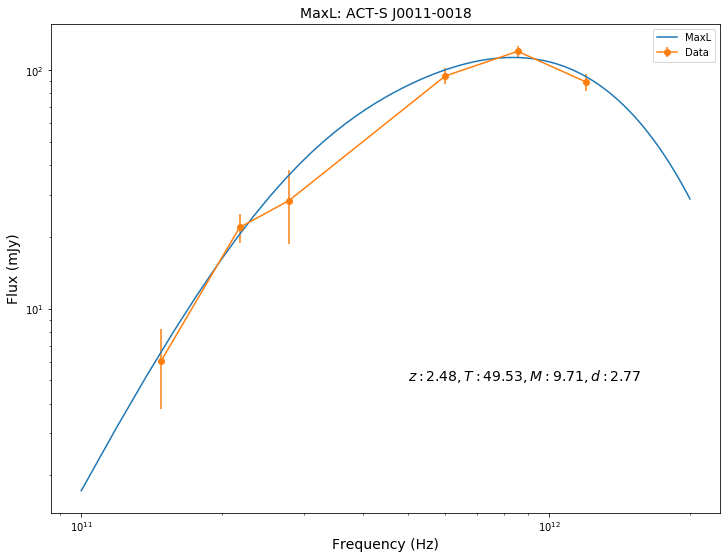

In [18]:
plt.figure(figsize=(12,9))

#plot de datos vs este fit
#(copy paste de arriba )

x0 = np.linspace(100,2000,100)*un.GHz
x0 = x0.to("Hz")

pm = [zm,Tm,Mm,dm]

y = fit_bb(x0,pm[0],pm[1],pm[2],pm[3])

plt.plot(x0,y,label="MaxL")
plt.errorbar(vf,np.array(frecs0T),yerr=np.array(errf0T),marker="o",label="Data")
plt.xscale("log")
plt.yscale("log")
plt.annotate(r"$z:{},T:{},M:{},d:{}$".format(np.round(zm,2),np.round(Tm,2),np.round(Mm,2),np.round(dm,2)),(5*10**11,5),fontsize=14)

plt.ylabel("Flux (mJy)",fontsize=14)
plt.xlabel("Frequency (Hz)",fontsize=14)
plt.title("MaxL: {}".format(ID[0]),fontsize=14)
plt.legend()

In [19]:
def ml(ID,z,T,M_,d_,frecsT,errfT): #recibe con unidades
    theta = [-1,z,T.value,M_,d_.value]
    

    n = lambda *args: -lnlike(*args)
    

    maxlike = op.minimize(n, theta, args=(vf,np.array(frecsT),np.array(errfT)))
    
    lnfM,zm,Tm,Mm,dm = maxlike["x"]
    
    plt.figure(figsize=(12,9))


    x0 = np.linspace(100,2000,100)*un.GHz
    x0 = x0.to("Hz")

    pm = [zm,Tm,Mm,dm]

    y = fit_bb(x0,pm[0],pm[1],pm[2],pm[3])

    plt.plot(x0,y,label="MaxL")
    plt.errorbar(vf,np.array(frecsT),yerr=np.array(errfT),marker="o",label="Data")
    plt.xscale("log")
    plt.yscale("log")
    plt.annotate(r"$z:{},T:{},M:{},d:{}$".format(np.round(zm,2),np.round(Tm,2),np.round(Mm,2),np.round(dm,2)),(5*10**11,5),fontsize=14)

    plt.ylabel("Flux (mJy)",fontsize=14)
    plt.xlabel("Frequency (Hz)",fontsize=14)
    plt.title("MaxL: {}".format(ID),fontsize=14)
    plt.legend()

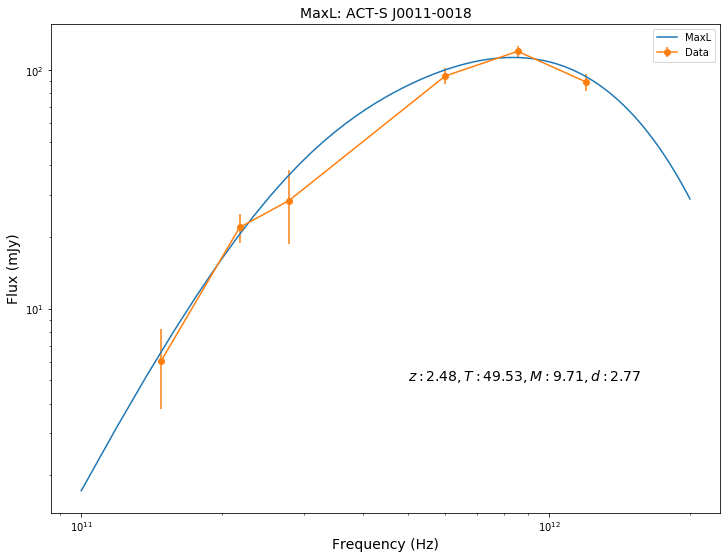

In [20]:
ml(ID[0],z0,T0,M0_,d0_,frecs0T,errf0T)

ACT-S J0022-0155

In [21]:
frecs1T=np.array([v1[1],v2[1],l1[1],l2[1],l3[1]])
errf1T=np.array([ev1[1],ev2[1],el1[1],el2[1],el3[1]])

In [22]:
frecs1=np.array([[v1[1],v2[1]],[l1[1],l2[1],l3[1]]])
errf1=np.array([[ev1[1],ev2[1]],[el1[1],el2[1],el3[1]]])

In [23]:
z1=4.4
T1=42.6*un.K
M1_=9.36
d1_=4.1*un.kpc

In [24]:
#ml(ID[1],z1,T1,M1_,d1_,frecs1T,errf1T)

ACT-S J0038_0022

In [25]:
frecs2T=np.array([v1[2],v2[2],v3[2],l1[2],l2[2],l3[2]])
errf2T=np.array([ev1[2],ev2[2],ev3[2],el1[2],el2[2],el3[2]])

In [26]:
frecs2=np.array([[v1[2],v2[2],v3[2]],[l1[2],l2[2],l3[2]]])
errf2=np.array([[ev1[2],ev2[2],ev2[2]],[el1[2],el2[2],el3[2]]])

In [27]:
z2=4.3
T2=45.5*un.K
M2_=9.35
d2_=3.3*un.kpc

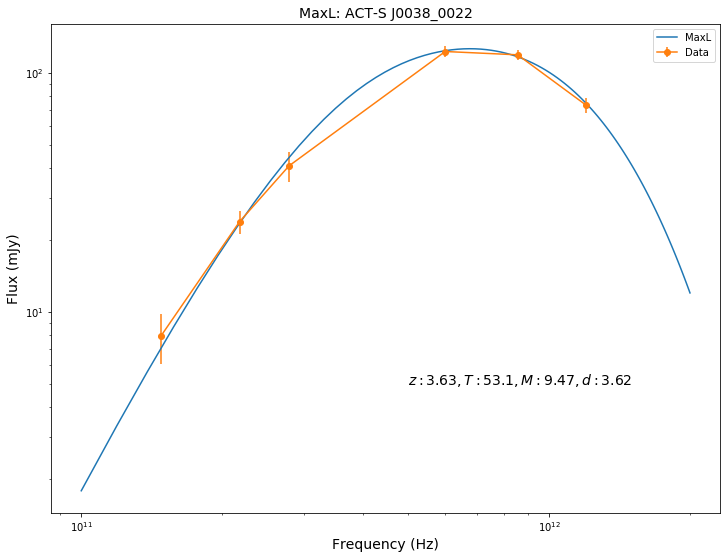

In [28]:
ml(ID[2],z2,T2,M2_,d2_,frecs2T,errf2T)

ACT-S J0039+0024

In [29]:
frecs3T=np.array([v1[3],v2[3],v3[3],l1[3],l2[3],l3[3]])
errf3T=np.array([ev1[3],ev2[3],ev3[3],el1[3],el2[3],el3[3]])

In [30]:
frecs3=np.array([[v1[3],v2[3],v3[3]],[l1[3],l2[3],l3[3]]])
errf3=np.array([[ev1[3],ev2[3],ev2[3]],[el1[3],el2[3],el3[3]]])

In [31]:
z3=3.3
T3=46.8*un.K
M3_=9.35
d3_=3.3*un.kpc

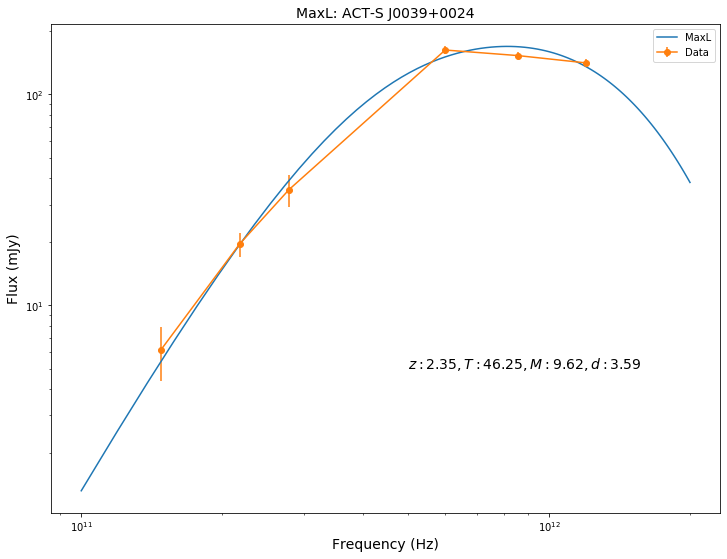

In [32]:
ml(ID[3],z3,T3,M3_,d3_,frecs3T,errf3T)

ACT-S J0044+0118

In [33]:
frecs4T=np.array([v1[4],v2[4],v3[4],l1[4],l2[4],l3[4]])
errf4T=np.array([ev1[4],ev2[4],ev3[4],el1[4],el2[4],el3[4]])

In [34]:
frecs4=np.array([[v1[4],v2[4],v3[4]],[l1[4],l2[4],l3[4]]])
errf4=np.array([[ev1[4],ev2[4],ev2[4]],[el1[4],el2[4],el3[4]]])

In [35]:
z4=4.9
T4=47.2*un.K
M4_=9.42
d4_=4.9*un.kpc

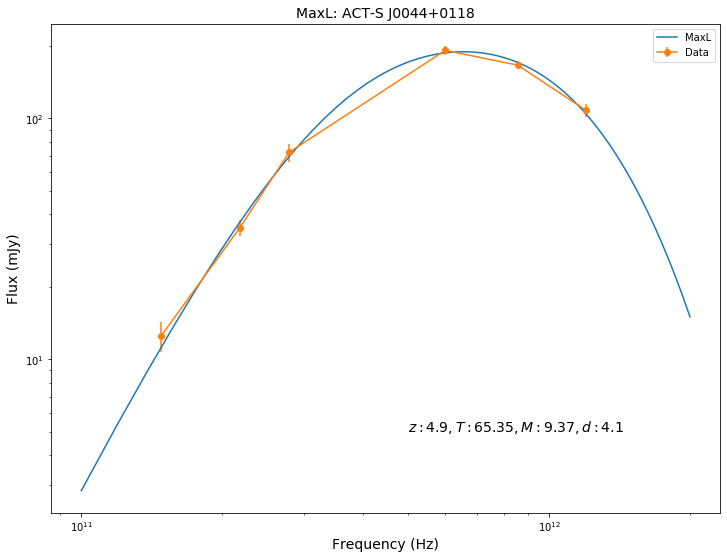

In [36]:
ml(ID[4],z4,T4,M4_,d4_,frecs4T,errf4T)

ACT-S J0045_0001

In [37]:
frecs5T=np.array([v1[5],v2[5],v3[5],l1[5],l2[5],l3[5]])
errf5T=np.array([ev1[5],ev2[5],ev3[5],el1[5],el2[5],el3[5]])

In [38]:
frecs5=np.array([[v1[5],v2[5],v3[5]],[l1[5],l2[5],l3[5]]])
errf5=np.array([[ev1[5],ev2[5],ev2[5]],[el1[5],el2[5],el3[5]]])

In [39]:
z5=4.6
T5=39.9*un.K
M5_=9.39
d5_=4.4*un.kpc

/opt/anaconda3/lib/python3.7/site-packages/astropy/cosmology/core.py:1251: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  args=self._inv_efunc_scalar_args)[0]
/opt/anaconda3/lib/python3.7/site-packages/astropy/cosmology/core.py:1251: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  args=self._inv_efunc_scalar_args)[0]
/opt/anaconda3/lib/python3.7/site-packages/astropy/cosmology/core.py:1251: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  args=self._inv_efunc_scalar_args)[0]


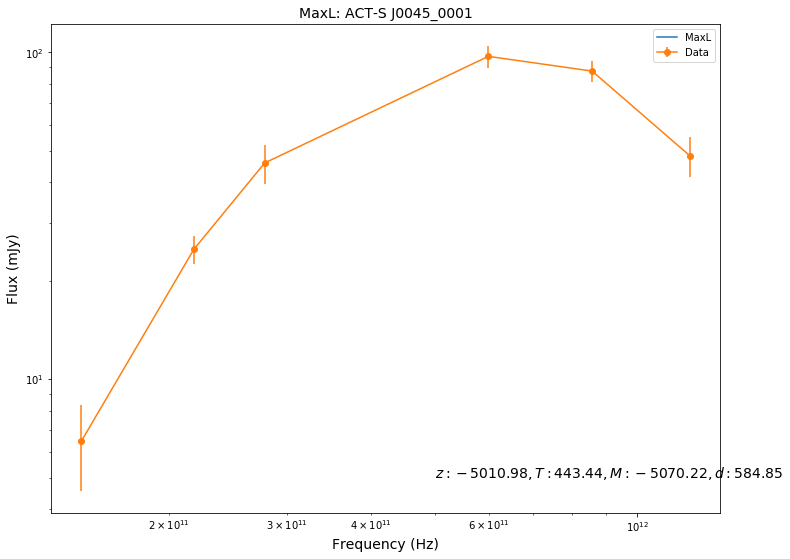

In [40]:
ml(ID[5],z5,T5,M5_,d5_,frecs5T,errf5T)

ACT-S J0107+0001 esp

In [42]:
frecs6T=np.array([v1[6],v2[6],v3[6],l1[6],l2[6],l3[6]])
errf6T=np.array([ev1[6],ev2[6],ev3[6],el1[6],el2[6],el3[6]])

In [43]:
frecs6=np.array([[v1[6],v2[6],v3[6]],[l1[6],l2[6],l3[6]]])
errf6=np.array([[ev1[6],ev2[6],ev2[6]],[el1[6],el2[6],el3[6]]])

In [45]:
z6_esp=3.332
T6_esp=35.1*un.K
M6_esp=9.42
d6_esp=3.9*un.kpc

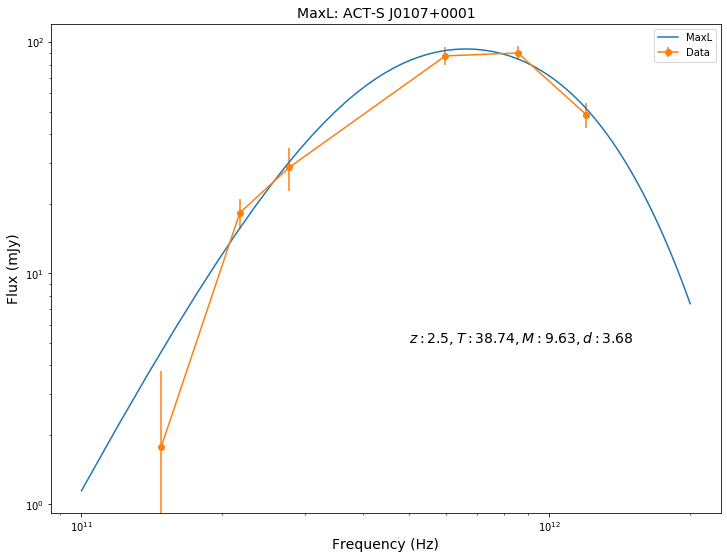

In [47]:
ml(ID[6],z6_esp,T6_esp,M6_esp,d6_esp,frecs6T,errf6T)

ACT-S J0107+0001 normal

In [48]:
z6=3.8
T6=37.2*un.K
M6_=9.31
d6_=4*un.kpc

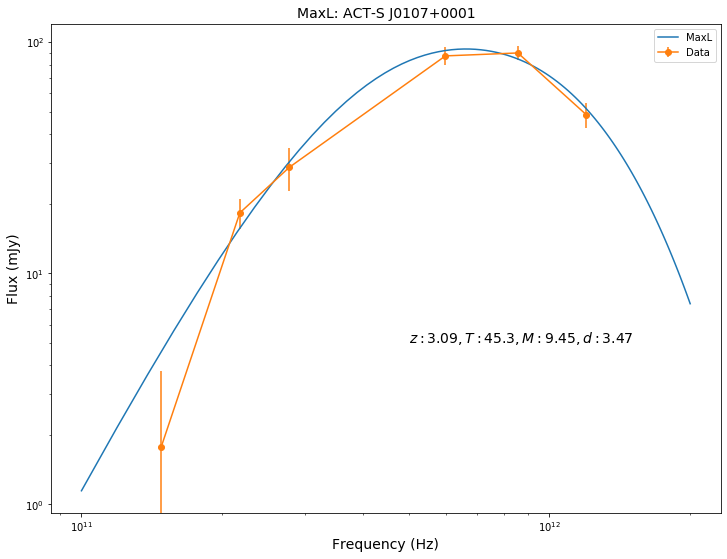

In [49]:
ml(ID[6],z6,T6,M6_,d6_,frecs6T,errf6T)

ACT-S J0116_0004

In [53]:
frecs7T=np.array([v1[7],v2[7],v3[7],l1[7],l2[7],l3[7]])
errf7T=np.array([ev1[7],ev2[7],ev3[7],el1[7],el2[7],el3[7]])

In [54]:
frecs7=np.array([[v1[7],v2[7],v3[7]],[l1[7],l2[7],l3[7]]])
errf7=np.array([[ev1[7],ev2[7],ev2[7]],[el1[7],el2[7],el3[7]]])

In [55]:
z7=3.9
T7=40.7*un.K
M7_=9.37
d7_=5.3*un.kpc

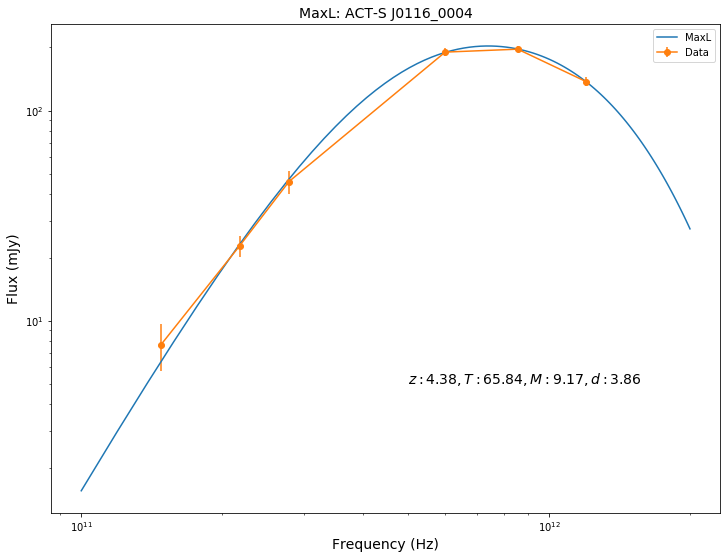

In [56]:
ml(ID[7],z7,T7,M7_,d7_,frecs7T,errf7T)

ACT-S J0210+0016 esp

In [59]:
frecs8T=np.array([v1[8],v2[8],v3[8],l1[8],l2[8],l3[8]])
errf8T=np.array([ev1[8],ev2[8],ev3[8],el1[8],el2[8],el3[8]])

In [60]:
frecs8=np.array([[v1[8],v2[8],v3[8]],[l1[8],l2[8],l3[8]]])
errf8=np.array([[ev1[8],ev2[8],ev2[8]],[el1[8],el2[8],el3[8]]])

In [62]:
z8_esp=2.553
T8_esp=42.3*un.K
M8_esp=10.02
d8_esp=7.4*un.kpc

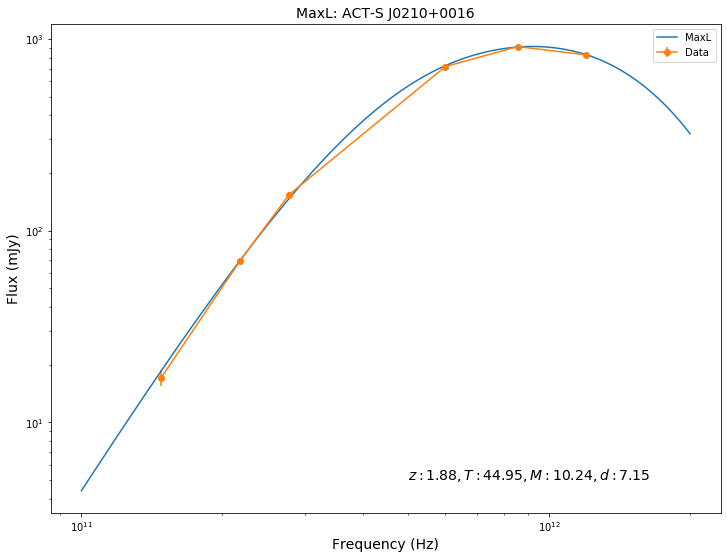

In [63]:
ml(ID[8],z8_esp,T8_esp,M8_esp,d8_esp,frecs8T,errf8T)

In [64]:
z8=2.7
T8=43.8*un.K
M8_=9.97
d8_=7.2*un.kpc

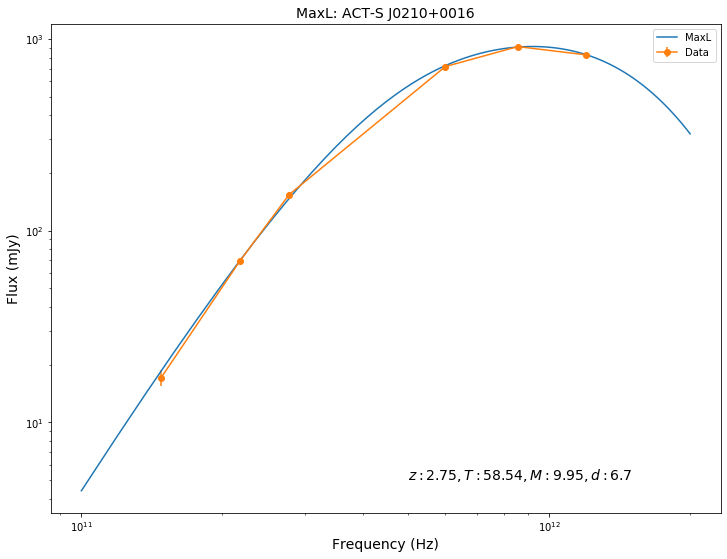

In [65]:
ml(ID[8],z8,T8,M8_,d8_,frecs8T,errf8T)